# House Price Prediction: Data Analysis, Visualization and Preprocessing

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import TargetEncoder, LabelEncoder, OneHotEncoder

### Helper Functions: Data Cleaning and Preprocessing
Below are the helper functions needed for data cleaning and data preprocessing pipeline.

In [2]:
def process_numeric_columns(dataframe, column_names):
    """
    Clean and convert numeric columns with range values to float64.

    Parameters:
    - dataframe (pd.DataFrame): The dataset.
    - column_names (list): List of column names to clean.

    Returns:
    - pd.DataFrame: The DataFrame with the specified columns cleaned and converted.
    """
    # Define a lambda function for range conversion
    range_conversion = lambda x: np.mean([float(val) for val in x.split(' to ')]) if ' to ' in str(x) else x
    # Apply the range conversion lambda function to each specified column
    dataframe[column_names] = dataframe[column_names].applymap(range_conversion)
    # Convert the entire columns to float
    dataframe[column_names] = dataframe[column_names].apply(pd.to_numeric, errors='coerce')
    return dataframe

def handle_missing_values(dataframe):
    """
    Impute missing values with mean for numeric columns and mode for object columns.

    Parameters:
    - dataframe (pd.DataFrame): The dataset.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    # Separate numeric and object columns
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    object_columns = dataframe.select_dtypes(include=['object']).columns.tolist()

    # Impute missing values with mean for numeric columns
    dataframe[numeric_columns] = dataframe[numeric_columns].apply(lambda x: x.fillna(x.mean()))

    # Impute missing values with mode for object columns
    dataframe[object_columns] = dataframe[object_columns].apply(lambda x: x.fillna(x.mode().iloc[0]))

    return dataframe

def target_encode(df, columns, target_column_name, encoder=None):
    """
    Target encode categorical columns in a DataFrame using TargetEncoder.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of columns to be target encoded.
    - target_column_name (str): The name of the target column for encoding.
    - encoder (TargetEncoder, optional): An optional pre-fit TargetEncoder instance.

    Returns:
    - pd.DataFrame: The DataFrame with target-encoded columns.
    - TargetEncoder: The encoder used for encoding.
    """
    if encoder is None:
        encoder = TargetEncoder()
        df_encoded = df.copy()
        df_encoded[columns] = encoder.fit_transform(df[columns], df[target_column_name])
        return df_encoded, encoder
    else:
        df_encoded = df.copy()
        df_encoded[columns] = encoder.transform(df[columns])
        return df_encoded, encoder

def label_encode_column(df, column_name, custom_mapping):
    """
    Custom label encode a column in a DataFrame based on a provided mapping,
    drop the original column, and rename the new column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column_name (str): The name of the column to be custom encoded.
    - custom_mapping (dict): A dictionary mapping original values to custom labels.

    Returns:
    - pd.DataFrame: The DataFrame with the original column dropped and the new encoded column.
    """
    new_column_name = column_name + '_encoded'

    df[new_column_name] = df[column_name].map(custom_mapping)

    # Drop the original column
    df.drop(columns=[column_name], inplace=True)

    # Rename the new column to the original column name
    df.rename(columns={new_column_name: column_name}, inplace=True)

    return df    
    
def dummy_encode(df, columns, drop_first=True):
    """
    Dummy encode categorical columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of columns to be dummy encoded.
    - drop_first (bool, optional): Whether to drop the first column of each dummy encoded category.

    Returns:
    - pd.DataFrame: The DataFrame with dummy encoded columns.
    """
    df_encoded = df.copy()
    df_encoded = pd.get_dummies(df_encoded, columns=columns, drop_first=drop_first, dtype=int)
    return df_encoded

def split_data(df, target_column, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split the DataFrame into training, validation, and testing sets.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - target_column (str): The name of the target column.
    - test_size (float): The proportion of the dataset to include in the test split.
    - val_size (float): The proportion of the dataset to include in the validation split.
    - random_state (int): Seed for random state.

    Returns:
    - X_train, X_val, X_test, y_train, y_val, y_test
    """
    # First, create train and test split
    train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)

    # Calculate the effective validation split size to ensure an equal number of samples
    effective_val_size = val_size / (1 - test_size)

    # Create the validation split from the train split
    train_data, val_data = train_test_split(train_data, test_size=effective_val_size, random_state=random_state)

    # Separate features and target variable
    X_train, y_train = train_data.drop(columns=[target_column]), train_data[target_column]
    X_val, y_val = val_data.drop(columns=[target_column]), val_data[target_column]
    X_test, y_test = test_data.drop(columns=[target_column]), test_data[target_column]

    return X_train, X_val, X_test, y_train, y_val, y_test

def save_data(X_train, X_val, X_test, y_train, y_val, y_test, path):
    """
    Save the training, validation, and testing sets to CSV files.

    Parameters:
    - X_train, X_val, X_test (pd.DataFrame): Feature sets for training, validation, and testing.
    - y_train, y_val, y_test (pd.Series): Target variables for training, validation, and testing.
    - path (str): Directory path to save the data.

    Returns:
    - train_data, val_data, test_data (pd.DataFrame): DataFrames with reset index values.
    """
    if not os.path.exists(path):
        os.makedirs(path)
    
    # Reset index before concatenating
    train_data = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    val_data = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
    test_data = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

    # Save to CSV files
    train_data.to_csv(f"{path}/train_data.csv", index=False)
    val_data.to_csv(f"{path}/val_data.csv", index=False)
    test_data.to_csv(f"{path}/test_data.csv", index=False)

    return train_data, val_data, test_data

def standardize_data(X_train, X_val, X_test):
    """
    Standardize the feature sets using StandardScaler.

    Parameters:
    - X_train, X_val, X_test (pd.DataFrame): Feature sets for training, validation and testing.

    Returns:
    - X_train_std, X_val_std, X_test_std, scaler
    """
    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit and transform on training data
    X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    # Transform validation data
    X_val_std = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    
    # Transform testing data
    X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train_std, X_val_std, X_test_std, scaler

def normalize_data(X_train, X_val, X_test):
    """
    Normalize the feature sets using MinMaxScaler.

    Parameters:
    - X_train, X_val, X_test (pd.DataFrame): Feature sets for training, validation and testing.

    Returns:
    - X_train_norm, X_val_norm, X_test_norm scaler
    """
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit and transform on training data
    X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    # Transform validation data
    X_val_norm = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    
    # Transform testing data
    X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train_norm, X_val_norm, X_test_norm, scaler

def save_scaler(scaler, path):
    """
    Save the scaler object to a pickle file.

    Parameters:
    - scaler: The scaler object (e.g., StandardScaler or MinMaxScaler).
    - path (str): Directory path to save the scaler.
    """
    if not os.path.exists(path):
        os.makedirs(path)
    with open(f"{path}/scaler.pkl", 'wb') as file:
        pickle.dump(scaler, file)

### Helper Functions:  Data Visualization
Below are the helper functions needed for data visualization.

In [3]:
def summary_statistics(dataframe):
    """
    Display summary statistics for numerical features in the dataset.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    - None
    """
    print(dataframe.describe())

def target_variable_distribution(dataframe, target_variable):
    """
    Plot the distribution of the target variable.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - target_variable (str): The name of the target variable.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataframe, x=target_variable, kde=True)
    plt.title(f'Distribution of {target_variable}')
    plt.show()

def correlation_analysis(dataframe):
    """
    Visualize the correlation matrix using a heatmap.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    - None
    """
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

def visualize_categorical_variables(dataframe):
    """
    Plot the distribution of all categorical variables in the DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    - None
    """
    categorical_variables = dataframe.select_dtypes(include='object').columns

    for categorical_variable in categorical_variables:
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(data=dataframe, x=categorical_variable)
        
        # Rotate x-axis labels vertically for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
        
        plt.title(f'Distribution of {categorical_variable}')
        plt.show()

def visualize_relationships(dataframe, feature1, feature2):
    """
    Visualize the relationship between two features using a scatter plot.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - feature1 (str): The name of the first feature.
    - feature2 (str): The name of the second feature.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=dataframe, x=feature1, y=feature2)
    plt.title(f'Relationship between {feature1} and {feature2}')
    plt.show()


## Load Dataset

In [4]:
file_path = 'Pune Real Estate Data.xlsx'

In [5]:
df = pd.read_excel(file_path)
df.shape

(200, 18)

## Rename columns and remove unnecessary columns
Renaming columns by removing white spaces makes it easier for us to access columns.

In [6]:
# Rename columns by replacing spaces with '_' and converting to lowercase
df.columns = df.columns.str.replace(' ', '_').str.lower()

Remove columns that may not add more information to a machine learning model.
1. 'sr_no': Serial number column does not adding information to the dataset.
2. 'price_in_millions': Price column in lakhs already available
3. 'description': Basic description of property 
4. 'location': No unique information available
5. 'total_township_area_in_acres': Too many missing values (149/200)

In [7]:
# Drop the unnecessary columns
df = df.drop(columns=[
    "sr._no.", 
    "price_in_millions",  # price column in lakhs already available
    "description",  # basic description of property 
    "location",  # no unique information available
    "total_township_area_in_acres",  # too many missing values (149/200)
])

## Preprocessing

In [8]:
# Display data types of each column
df.dtypes

sub-area                            object
propert_type                        object
property_area_in_sq._ft.            object
price_in_lakhs                      object
company_name                        object
township_name/_society_name         object
clubhouse                           object
school_/_university_in_township_    object
hospital_in_township                object
mall_in_township                    object
park_/_jogging_track                object
swimming_pool                       object
gym                                 object
dtype: object

Observation made: Columns like 'property_area_in_sq._ft.' and 'price_in_lakhs' should be float64. Data cleaning is necessary.

### Convert desired columns to numeric type

In [9]:
## List of numeric columns
columns_to_convert = ["property_area_in_sq._ft.", "price_in_lakhs"]
## Convert column to numeric types
df = process_numeric_columns(df, columns_to_convert)

### Check and Handle missing values

In [10]:
## Check for null values in the entire DataFrame
df.isnull().sum()

sub-area                            0
propert_type                        0
property_area_in_sq._ft.            2
price_in_lakhs                      1
company_name                        0
township_name/_society_name         0
clubhouse                           0
school_/_university_in_township_    0
hospital_in_township                0
mall_in_township                    0
park_/_jogging_track                0
swimming_pool                       0
gym                                 0
dtype: int64

In [11]:
## Impute missing values: mean for numeric columns and mode for categorical columns
df = handle_missing_values(df)

### Remove white spaces and lowercase string values in categorical columns

In [12]:
# Apply strip and lowercase to each specified column (remove white spaces and lowercase)
columns_to_process = df.select_dtypes(include=['object']).columns.tolist()
df[columns_to_process] = df[columns_to_process].applymap(lambda x: ''.join(str(x).split()).lower())

### Data Visualization: Check unique values and its distribution (categorical columns)
Visualizing the categorical columns helps us understand how the intitial data cleaning has affected the categorical columns. It also gives us an idea about the feature distribution, balance vs imbalanced features and outliers.

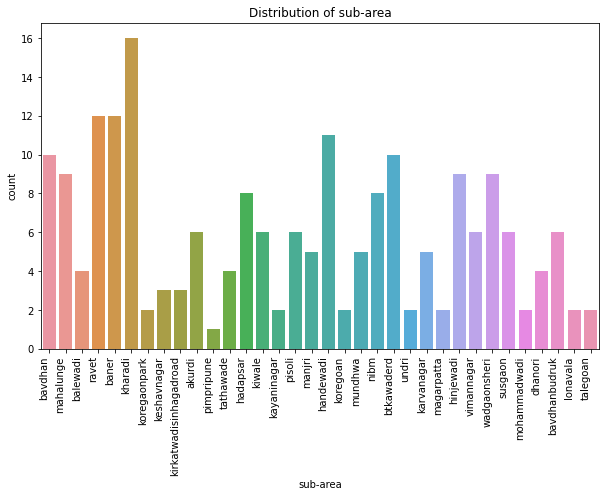

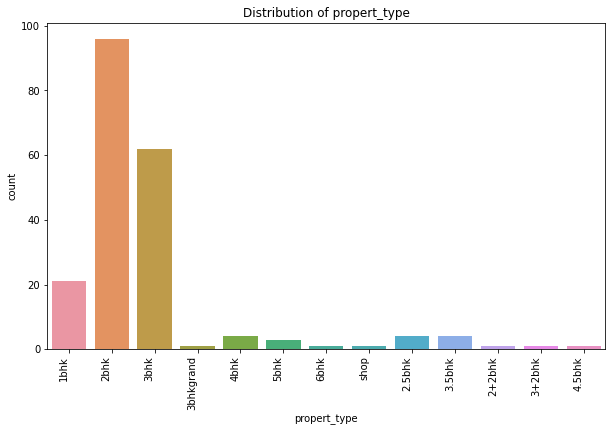

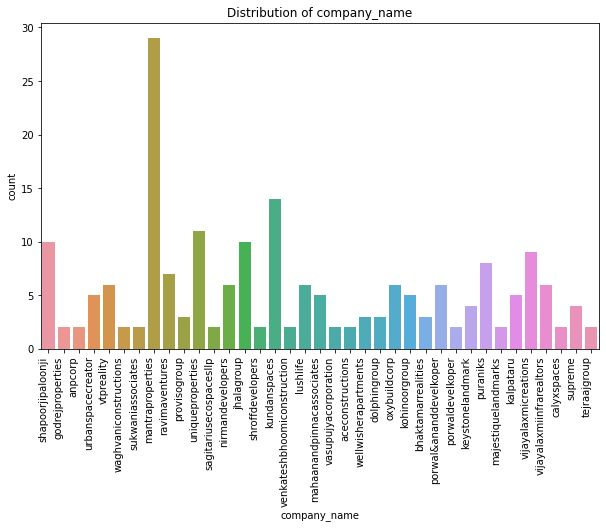

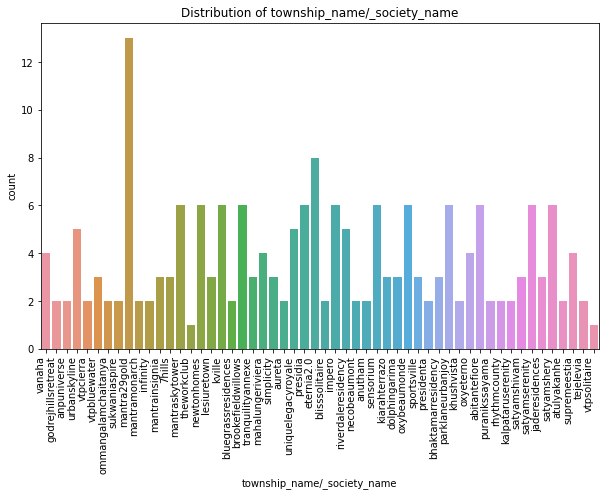

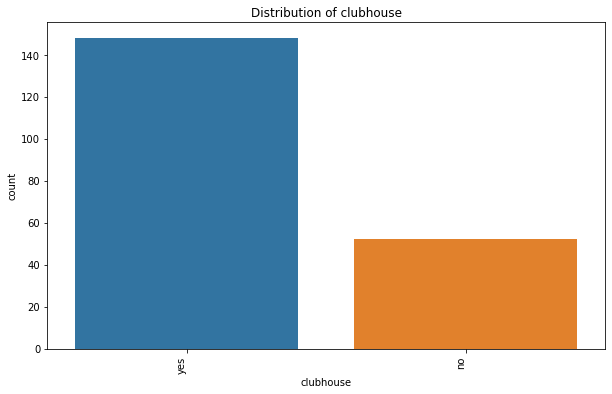

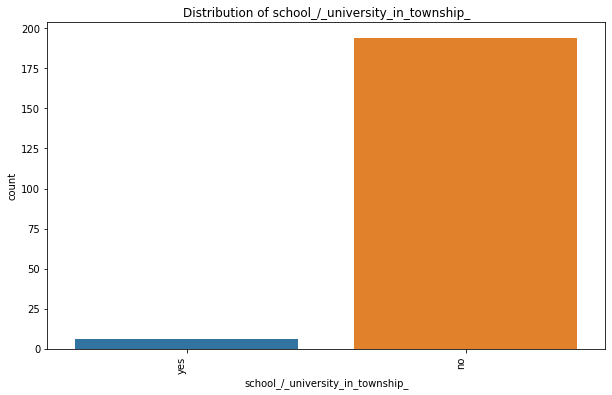

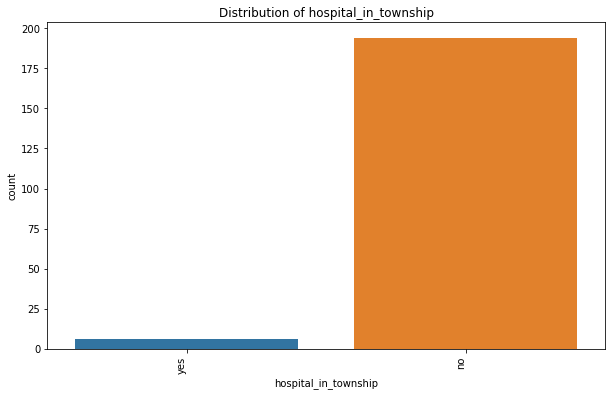

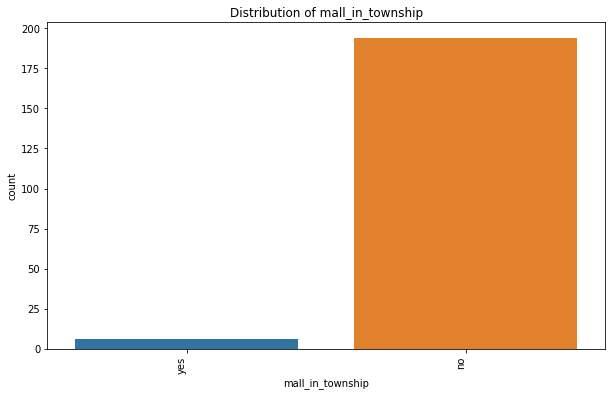

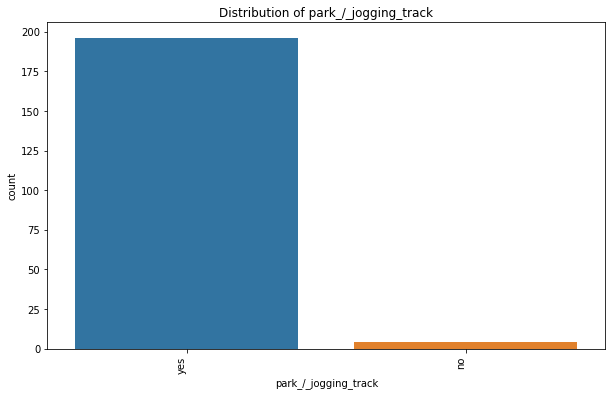

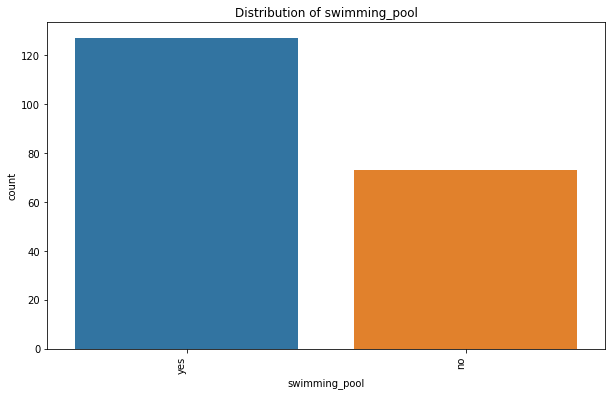

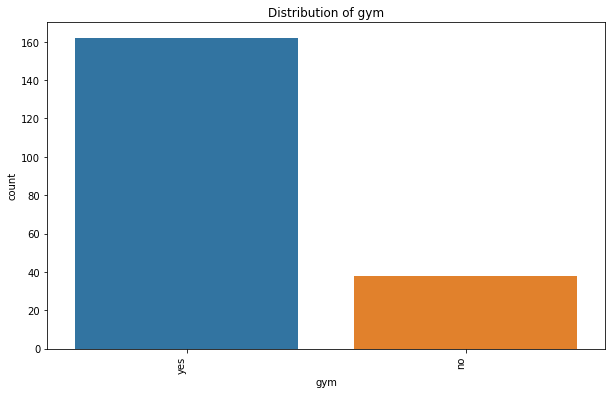

In [13]:
# Visualize all the categorical variables
visualize_categorical_variables(df)

### Encoding categorical columns

In [14]:
# Target Encoding for high cardinality columns
cols = ['sub-area', 'company_name', 'township_name/_society_name', 'propert_type']
df, target_encoder = target_encode(df, columns=cols, target_column_name='price_in_lakhs')

# One-Hot Encoding for binary columns
cols = ['clubhouse', 'school_/_university_in_township_', 'hospital_in_township', 
        'mall_in_township', 'park_/_jogging_track', 'swimming_pool', 'gym']
df = dummy_encode(df, columns=cols, drop_first=True)

In [15]:
# Print Summary Stats
summary_statistics(df)

         sub-area  propert_type  property_area_in_sq._ft.  price_in_lakhs  \
count  200.000000    200.000000                200.000000      200.000000   
mean    88.721617     90.773535                888.583333       95.258291   
std     46.943957     42.801790                375.954059      101.613566   
min     13.190000     35.986413                113.000000       13.190000   
25%     61.173702     63.847374                670.000000       51.750000   
50%     76.298683     65.829881                800.500000       71.250000   
75%    109.250295    125.090989               1030.500000       99.152500   
max    460.000000    250.530078               2447.000000      930.000000   

       company_name  township_name/_society_name  clubhouse_yes  \
count    200.000000                   200.000000     200.000000   
mean      88.339378                    89.303511       0.740000   
std       45.190450                    50.691209       0.439735   
min       13.190000                   

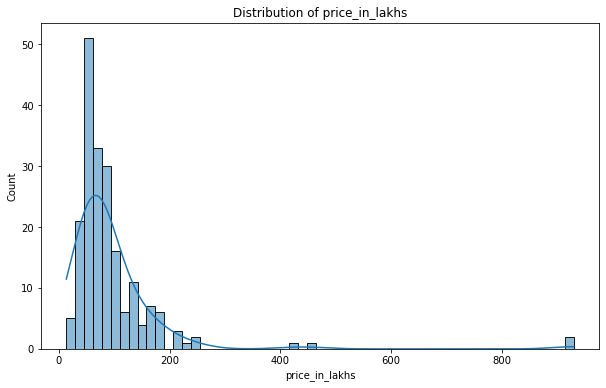

In [16]:
target_variable_distribution(df,'price_in_lakhs')

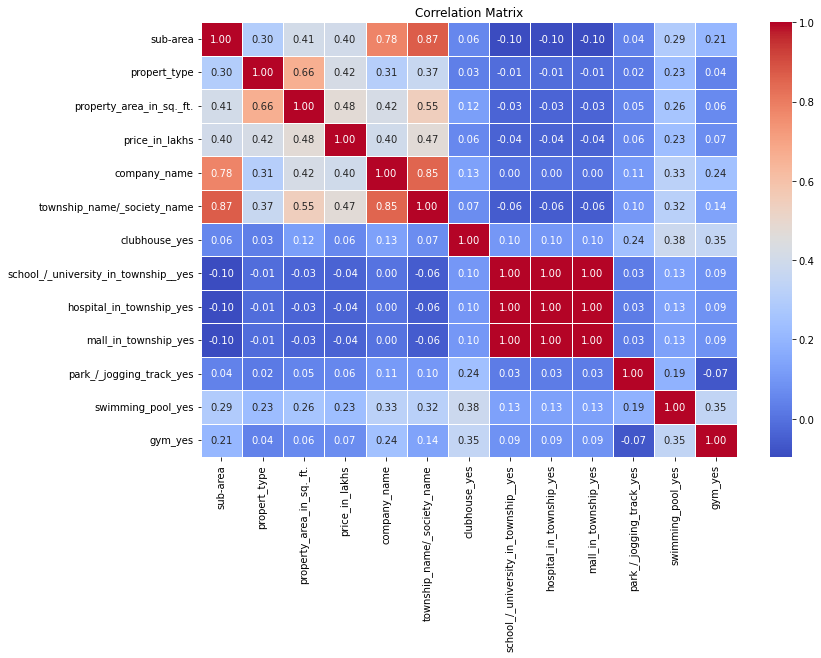

In [17]:
correlation_analysis(df)

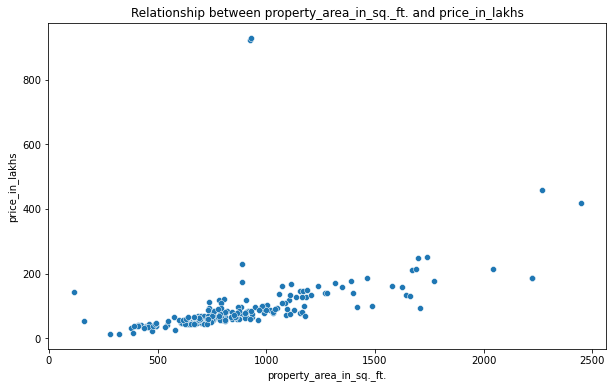

In [18]:
visualize_relationships(df,'property_area_in_sq._ft.', 'price_in_lakhs')

The above visualizations show the presence of a few outliers. These outliers can be handled by applying the log transformations over the entire dataset.

### Perform log transformaiton to handle outliers

In [19]:
## Log transformation to handle outliers
df = np.log1p(df)
df

,sub-area,propert_type,property_area_in_sq._ft.,price_in_lakhs,company_name,township_name/_society_name,clubhouse_yes,school_/_university_in_township__yes,hospital_in_township_yes,mall_in_township_yes,park_/_jogging_track_yes,swimming_pool_yes,gym_yes
0,4.115079,3.642482,6.200509,3.688879,4.564465,4.344644,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
1,4.050982,4.188251,6.652863,4.189655,4.570221,4.229972,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
2,4.129932,4.966518,6.791221,4.317488,4.558374,4.185112,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
3,4.004232,4.529763,6.926577,4.499810,4.382888,4.104717,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
4,4.363924,4.202150,6.612041,4.317488,4.564348,4.564348,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5.039391,4.821915,7.208600,5.081404,5.116425,5.116425,0.693147,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147
196,5.042098,5.259155,6.790753,5.442418,4.804649,4.804649,0.693147,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147
197,5.042098,4.172970,6.672033,4.564348,4.912655,4.912655,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147
198,5.128409,4.949988,7.010312,4.912655,4.564348,4.564348,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147


In [20]:
# ## Inverse transformation to recover original values
# df_original = np.expm1(df)

### Split data: train-test-val
Split the data before any furthe rpre-processing steps like standardic=zationa nd normalization to prevent test data leakage into the model.

In [21]:
# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    df=df, target_column='price_in_lakhs', test_size=0.1, val_size=0.1, random_state=42
)

# Save the split data
train_data, val_data, test_data = save_data(X_train, X_val, X_test, y_train, y_val, y_test, path='processed_data/split_data')

In [22]:
# Print the shapes
print("X_train shape:", X_train.shape, type(X_train))
print("y_train shape:", y_train.shape, type(y_train))
print("---")
print("X_val shape:", X_val.shape, type(X_val))
print("y_val shape:", y_val.shape, type(y_val))
print("---")
print("X_test shape:", X_test.shape, type(X_test))
print("y_test shape:", y_test.shape, type(y_test))

X_train shape: (160, 12) <class 'pandas.core.frame.DataFrame'>
y_train shape: (160,) <class 'pandas.core.series.Series'>
---
X_val shape: (20, 12) <class 'pandas.core.frame.DataFrame'>
y_val shape: (20,) <class 'pandas.core.series.Series'>
---
X_test shape: (20, 12) <class 'pandas.core.frame.DataFrame'>
y_test shape: (20,) <class 'pandas.core.series.Series'>


### Standardize the original data

In [23]:
# Standardize the data
X_train_std, X_val_std, X_test_std, std_scaler = standardize_data(X_train, X_val, X_test)
train_data_std, val_data_std, test_data_std = save_data(X_train_std, X_val_std, X_test_std, y_train, y_val, y_test, path='processed_data/standardized_data')
save_scaler(std_scaler, path='processed_data/standardized_data')

In [24]:
# Print the shapes
print("X_train shape:", X_train_std.shape, type(X_train_std))
print("y_train shape:", y_train.shape, type(y_train))
print("---")
print("X_val shape:", X_val_std.shape, type(X_val_std))
print("y_val shape:", y_val.shape, type(y_val))
print("---")
print("X_test shape:", X_test_std.shape, type(X_test_std))
print("y_test shape:", y_test.shape, type(y_test))

X_train shape: (160, 12) <class 'pandas.core.frame.DataFrame'>
y_train shape: (160,) <class 'pandas.core.series.Series'>
---
X_val shape: (20, 12) <class 'pandas.core.frame.DataFrame'>
y_val shape: (20,) <class 'pandas.core.series.Series'>
---
X_test shape: (20, 12) <class 'pandas.core.frame.DataFrame'>
y_test shape: (20,) <class 'pandas.core.series.Series'>


### Normalize the original data

In [25]:
# Normalize the original data
X_train_norm, X_val_norm, X_test_norm, norm_scaler = normalize_data(X_train, X_val, X_test)
train_data_norm, val_data_norm, test_data_norm = save_data(X_train_norm, X_val_norm, X_test_norm, y_train, y_val, y_test, path='processed_data/normalized_data')
save_scaler(norm_scaler, path='processed_data/normalized_data')

In [26]:
# Print the shapes
print("X_train shape:", X_train_norm.shape, type(X_train_norm))
print("y_train shape:", y_train.shape, type(y_train))
print("---")
print("X_val shape:", X_val_norm.shape, type(X_val_norm))
print("y_val shape:", y_val.shape, type(y_val))
print("---")
print("X_test shape:", X_test_norm.shape, type(X_test_norm))
print("y_test shape:", y_test.shape, type(y_test))

X_train shape: (160, 12) <class 'pandas.core.frame.DataFrame'>
y_train shape: (160,) <class 'pandas.core.series.Series'>
---
X_val shape: (20, 12) <class 'pandas.core.frame.DataFrame'>
y_val shape: (20,) <class 'pandas.core.series.Series'>
---
X_test shape: (20, 12) <class 'pandas.core.frame.DataFrame'>
y_test shape: (20,) <class 'pandas.core.series.Series'>


Both standardization and normalization have been implemented to assess their respective effects on model training. This approach involves testing the model with both normalized and standardized data to determine which yields the best results.